##  用注意力模型实现翻译-从基础实现

- 核心锻炼目标
    - 理解 Attention model的机制
    - 用keras 搭建 Attention model
    -  数据集的准备
    - Attention 如何画出来

## 1 理解 Attention model的机制
- 基本构成： pre_Bidirectional_LSTM + Attention +Post-LSTM
<img src="Attention.png" style="width:1200px;height:700px;">



## 2 用 keras 搭建 Attention model
- 样例的训练是基于字符级别的训练 
- RNN训练过程比较慢，可能是没有办法有效利用GPU的原因吧

In [1]:
# 事先将数据集导入
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

dataset[:10]

Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)


index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Using TensorFlow backend.
100%|██████████| 10000/10000 [00:00<00:00, 23120.74it/s]


X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)
Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### 从零开始写Attention model

#### [LSTM  的`return_sequence` 的意思](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/) [理解LSTM在keras API中参数return_sequences和return_state](https://blog.csdn.net/u011327333/article/details/78501054)

```
return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence.
return_state: Boolean. Whether to return the last state in addition to the output.

return_sequences: 返回最后state，还是全部state。为True时返回全部state
return_state: 只返回hidden state，还是 hidden state+cell state。为True时返回 hidden state+cell state

```

#### Bidirectional的 `input_shape`的意思


In [2]:
def softmax(x,axis=1):
    ndim=K.ndim(x)
    if ndim==2:
        return K.softmax(x)
    elif ndim>2:
        e=K.exp(x-K.max(x,axis=axis,keepdims=True))
        s=K.sum(e,axis=axis,keepdims=True)
        return e/s
    else:
        raise ValueError("Cannot apply softmax to a tensor that is 1D")
    
    

#### 【bug】`shape=(n_s) `要改为 `shape=(n_s,) `
``` 
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-26-fdcaaa099534> in <module>()
     21 
     22 s0=Input(shape=(n_s,),name='s0')
---> 23 c0=Input(shape=(n_s),name='c0')
     24 
     25 s=s0

~/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py in Input(shape, batch_shape, name, dtype, sparse, tensor)
   1430                        'dimension.')
   1431     if shape and not batch_shape:
-> 1432         batch_shape = (None,) + tuple(shape)
   1433     input_layer = InputLayer(batch_input_shape=batch_shape,
   1434                              name=name, dtype=dtype,

TypeError: 'int' object is not iterable
```

#### 【bug】`    alphas=Activation(softmax,name='activation_weights')(energies) ` 忘记提供输入，导致返回结果是 layer

```

ValueError                                Traceback (most recent call last)
<ipython-input-29-a96280c8bf57> in <module>()
     39     print(alphas)
     40     print(a)
---> 41     context=Dot(axes=1)([alphas,a])
     42 
     43 

~/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py in __call__(self, inputs, **kwargs)
    556                 # Raise exceptions in case the input is not compatible
    557                 # with the input_spec specified in the layer constructor.
--> 558                 self.assert_input_compatibility(inputs)
    559 
    560                 # Collect input shapes to build layer.

~/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py in assert_input_compatibility(self, inputs)
    429                                  'Received type: ' +
    430                                  str(type(x)) + '. Full input: ' +
--> 431                                  str(inputs) + '. All inputs to the layer '
    432                                  'should be tensors.')
    433 

ValueError: Layer dot_3 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.layers.core.Activation'>. Full input: [<keras.layers.core.Activation object at 0x7fe9df16af98>, <tf.Tensor 'bidirectional_6/concat_2:0' shape=(?, ?, 64) dtype=float32>]. All inputs to the layer should be tensors.

```


#### 【bug】 自己模型参数 为 368,320，而例题中参数为 52,960（详细推导）。会不会是不该共享的参数共享出去了？

- debug过程中的错误，把 36万误认为 3万，一直在努力去找哪些参数少算了
- 实际中的错误：有循环时，不能在循环体内声明新的layer，会导致layer的重复 


```
错误的做法
for t in  range(Ty):
    s_prev=s
    s_prev=RepeatVector(Tx)(s_prev)
    concat=Concatenate(axis=-1)([a,s_prev])
    e=Dense(10,activation='tanh')(concat)
    energies=Dense(1,activation='relu')(e)
    alphas=Activation(softmax,name='activation_weights_{}'.format(t))(energies)
    context=Dot(axes=1)([alphas,a])
    s,_,c=LSTM(n_s,return_state=True)(context,initial_state=[s,c])
    out=Dense(len(machine_vocab),activation=softmax)(s)
    outputs.append(out)
    
正确的做法

repeator=RepeatVector(Tx)
concatenator=Concatenate(axis=-1)
densor1=Dense(10,activation='tanh')
densor2=Dense(1,activation='relu')
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

post_activation_LSTM_cell=LSTM(n_s,return_state=True)
output_layer=Dense(len(machine_vocab),activation=softmax)

for t in  range(Ty):
    s_prev=s
    s_prev=repeator(s_prev)
    concat=concatenator([a,s_prev])
    e=densor1(concat)
    energies=densor2(e)
    alphas=activator(energies)
    context=dotor([alphas,a])
    s,_,c=post_activation_LSTM_cell(context,initial_state=[s,c])
    out=output_layer(s)
    outputs.append(out)
model=Model(inputs=[X,s0,c0],outputs=outputs)

```


- Bi-LSTM模型参数数量 n_a=32 n_x=37 4的意思是（3个门+cell计算值）
    - (2)(4)(n_a)(n_a+n_x+1)=(2)(4)(32)(32+37+1)=17920

- dense_1 参数数量
    - (128+1)(10)=1290

- dense_2 参数数量 
    - (10+1)(1)=11
- LSTM 参数 n_a=64  n_y=64  
    - (4)(n_a)(n_a+n_x+1)=4(64)(129)=33024
- dense_3 (64+1)(11) =715

In [23]:
#     Arguments:
#     Tx -- length of the input sequence
#     Ty -- length of the output sequence
#     n_a -- hidden state size of the Bi-LSTM
#     n_s -- hidden state size of the post-attention LSTM
#     human_vocab_size -- size of the python dictionary "human_vocab"
#     machine_vocab_size -- size of the python dictionary "machine_vocab"

# model size


Tx,Ty,n_a,n_s,human_vocab_size,machine_vocab_size=Tx,Ty,n_a,n_s,len(human_vocab),len(machine_vocab)
print("Tx",Tx)
print("Ty",Ty)
print("n_a",n_a)
print("n_s",n_s)
print("human_vocab_size",human_vocab_size)
print("machine_vocab_size",machine_vocab_size)

# pre-LSTM
X=Input(shape=(Tx,human_vocab_size))
a=Bidirectional(LSTM(n_a,return_sequences=True),input_shape=(m,Tx,n_a*2))(X)

s0=Input(shape=(n_s,),name='s0')
c0=Input(shape=(n_s,),name='c0')

s=s0
c=c0

outputs=[]

repeator=RepeatVector(Tx)
concatenator=Concatenate(axis=-1)
densor1=Dense(10,activation='tanh')
densor2=Dense(1,activation='relu')
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

post_activation_LSTM_cell=LSTM(n_s,return_state=True)
output_layer=Dense(len(machine_vocab),activation=softmax)

for t in  range(Ty):
    s_prev=s
    s_prev=repeator(s_prev)
    concat=concatenator([a,s_prev])
    e=densor1(concat)
    energies=densor2(e)
    alphas=activator(energies)
    context=dotor([alphas,a])
    s,_,c=post_activation_LSTM_cell(context,initial_state=[s,c])
    out=output_layer(s)
    outputs.append(out)
model=Model(inputs=[X,s0,c0],outputs=outputs)

model.summary()    


Tx 30
Ty 10
n_a 32
n_s 64
human_vocab_size 37
machine_vocab_size 11
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_13 (Bidirectional) (None, 30, 64)        17920       input_13[0][0]                   
____________________________________________________________________________________________________
repeat_vector_76 (RepeatVector)  (None, 30, 64)        0           s0[0][0]                         
                       

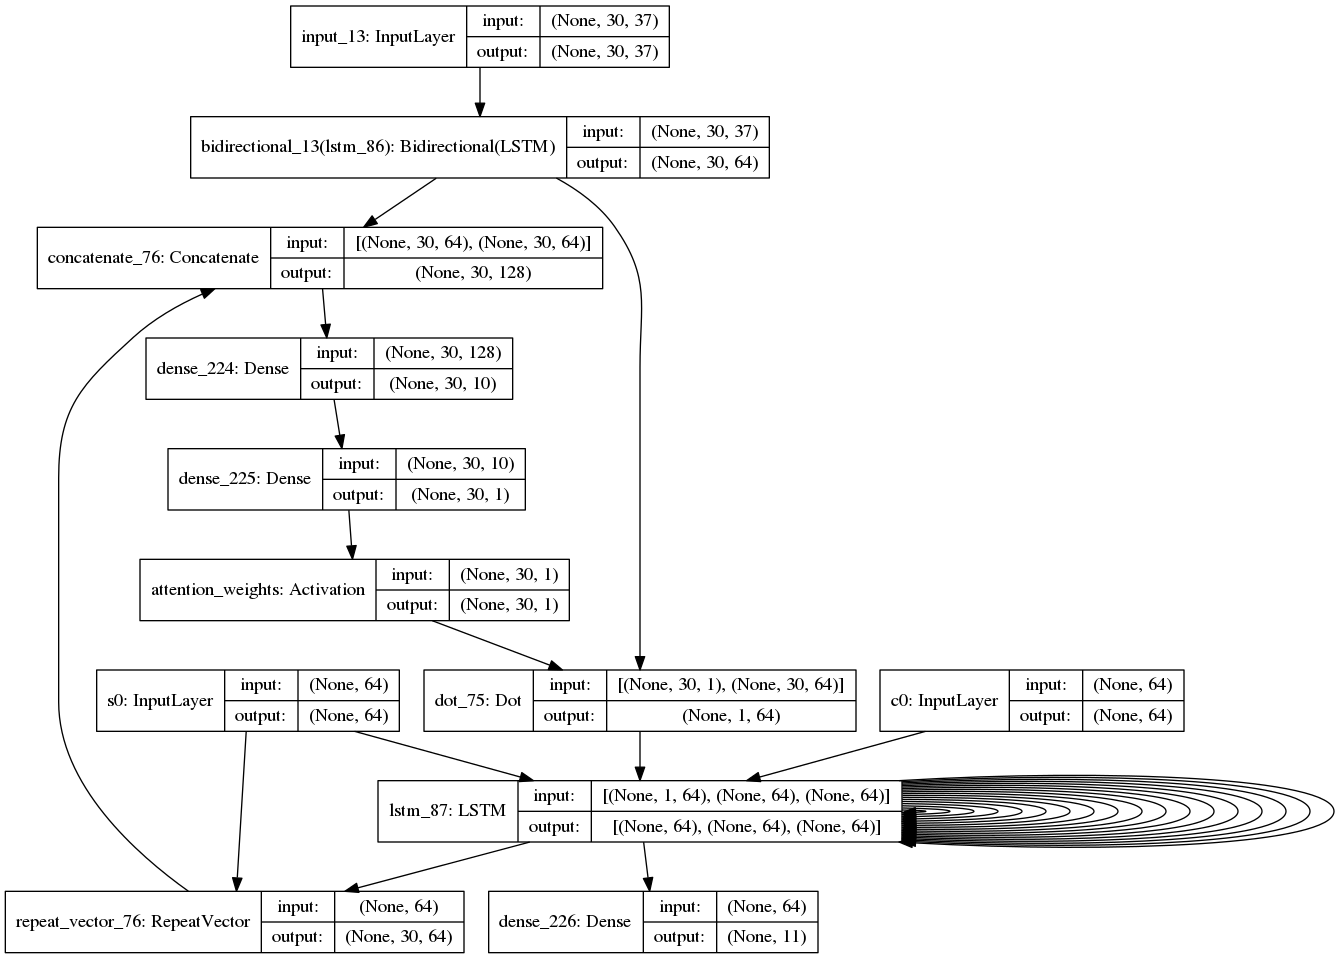

In [24]:
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# 保存到文件
plot_model(model,to_file="Attention_structure_test.png",show_shapes=True)
# notebook显示
SVG(model_to_dot(model).create(prog='dot',format='svg'))

from PIL import Image

# 显示本地图片
Image.open("Attention_structure_test.png")


In [27]:
opt=Adam(lr=0.005,beta_1=0.9,beta_2=0.999,decay=0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
s0=np.zeros((m,n_s))
c0=np.zeros((m,n_s))
outputs=list(Yoh.swapaxes(0,1))
model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100)

Epoch 1/20
10000/10000 [==============================] - 14s - loss: 11.4900 - dense_226_loss_1: 0.5620 - dense_226_loss_2: 0.4490 - dense_226_loss_3: 1.4196 - dense_226_loss_4: 2.3846 - dense_226_loss_5: 0.0822 - dense_226_loss_6: 0.6148 - dense_226_loss_7: 2.2467 - dense_226_loss_8: 0.1095 - dense_226_loss_9: 1.3075 - dense_226_loss_10: 2.3140 - dense_226_acc_1: 0.7681 - dense_226_acc_2: 0.8291 - dense_226_acc_3: 0.3730 - dense_226_acc_4: 0.1200 - dense_226_acc_5: 0.9900 - dense_226_acc_6: 0.7369 - dense_226_acc_7: 0.2061 - dense_226_acc_8: 0.9899 - dense_226_acc_9: 0.3723 - dense_226_acc_10: 0.1361    
Epoch 2/20
10000/10000 [==============================] - 11s - loss: 9.2873 - dense_226_loss_1: 0.2409 - dense_226_loss_2: 0.1343 - dense_226_loss_3: 1.0744 - dense_226_loss_4: 2.2094 - dense_226_loss_5: 0.0179 - dense_226_loss_6: 0.3986 - dense_226_loss_7: 1.8024 - dense_226_loss_8: 0.0152 - dense_226_loss_9: 1.2090 - dense_226_loss_10: 2.1853 - dense_226_acc_1: 0.9643 - dense_226_

10000/10000 [==============================] - 11s - loss: 0.5497 - dense_226_loss_1: 0.0197 - dense_226_loss_2: 0.0092 - dense_226_loss_3: 0.0484 - dense_226_loss_4: 0.0547 - dense_226_loss_5: 0.0024 - dense_226_loss_6: 0.0554 - dense_226_loss_7: 0.1527 - dense_226_loss_8: 0.0037 - dense_226_loss_9: 0.1357 - dense_226_loss_10: 0.0678 - dense_226_acc_1: 0.9951 - dense_226_acc_2: 0.9997 - dense_226_acc_3: 0.9974 - dense_226_acc_4: 1.0000 - dense_226_acc_5: 1.0000 - dense_226_acc_6: 0.9840 - dense_226_acc_7: 0.9586 - dense_226_acc_8: 0.9998 - dense_226_acc_9: 0.9720 - dense_226_acc_10: 0.9906    
Epoch 15/20
10000/10000 [==============================] - 11s - loss: 0.4659 - dense_226_loss_1: 0.0171 - dense_226_loss_2: 0.0080 - dense_226_loss_3: 0.0393 - dense_226_loss_4: 0.0461 - dense_226_loss_5: 0.0022 - dense_226_loss_6: 0.0508 - dense_226_loss_7: 0.1371 - dense_226_loss_8: 0.0033 - dense_226_loss_9: 0.1081 - dense_226_loss_10: 0.0539 - dense_226_acc_1: 0.9964 - dense_226_acc_2: 0.99

In [28]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2099-04-04
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


## 0 生成数据集
#### Faker: 伪造数据生成器
#### babel: Babel 是Python 的一个国际化工具包

#### Tqdm 是一个快速，可扩展的Python进度条，可以在Python 长循环中添加一个进度提示信息，用户只需要封装任意的迭代器 tqdm(iterator)。


#### tuple(h): 将str转换为tuple
```

h
'august 2 1998'

tuple(h)
('a', 'u', 'g', 'u', 's', 't', ' ', '2', ' ', '1', '9', '9', '8')
```

####  set.update(tuple) 更新set中的元素

#### 等价方法  
```
[vocab[i] if i in vocab.keys() else vocab['<unk>'] for i in string  ]

list(map(lambda x:vocab.get(x,'<unk>'),string))

```

In [21]:
from faker import Faker
import numpy as np
from babel.dates import format_date
import random
from tqdm import tqdm
from keras.utils import to_categorical


fake=Faker()
fake.seed(12345)
random.seed(12345)

FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']
LOCALES=['en_US']

def load_date():
    dt=fake.date_object()
    try:
        human_readable=format_date(dt,format=random.choice(FORMATS),locale='en_US')
        human_readable=human_readable.lower()
        human_readable=human_readable.replace(',','')
        machine_readable=dt.isoformat()
    except AttributeError as e:
        return None,None,None
    
    return human_readable,machine_readable,dt

def load_dataset(m):
    human_vocab=set()
    machine_vocab=set()
    dataset=[]
    Tx=30

    for i in tqdm(range(m)):
        h,m,_=load_date()
        if h is not None:
            dataset.append((h,m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    #  set 转换为 dict
    human=dict(zip(sorted(human_vocab)+['<unk>','<pad>'],list(range(len(human_vocab)+2))))
    inv_machine=dict(enumerate(sorted(machine_vocab)))
    machine={v:k for k,v in inv_machine.items()}
    return dataset,human,machine,inv_machine
    
def string_to_int(string,length,vocab):
    string=string.lower().replace(',','')
    if len(string)<length:
        string=string[:length]
    rep=list(map(lambda x:vocab.get(x,'<unk>'),string))    
    if len(string)<length:
        rep+=[vocab['<pad>']]*(length-len(string))
    return rep       


In [22]:
m = 100
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)


Tx=30
Ty=10


100%|██████████| 100/100 [00:00<00:00, 9531.64it/s]


In [20]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '<pad>': 36,
 '<unk>': 35,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [19]:
machine_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [11]:
X, Y = zip(*dataset)
X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

ValueError: invalid literal for int() with base 10: '<unk>'

In [14]:
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt

fake = Faker()
fake.seed(12345)
random.seed(12345)

# Define format of the data we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# change this if you want it to work with another language
LOCALES = ['en_US']

def load_date():
    """
        Loads some fake dates 
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)


Tx=30
Ty=10


100%|██████████| 10000/10000 [00:00<00:00, 23729.34it/s]


In [15]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '<pad>': 36,
 '<unk>': 35,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [16]:
machine_vocab

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [12]:
machine_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [62]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

In [63]:
X,Y=zip(*dataset)
X=np.array([string_to_int(i,Tx,human_vocab) for i in X])
Y=[string_to_int(t,Ty,machine_vocab) for t in Y]
# Xoh=np.array(list(map(lambda x: to_categorical(x,num_classes=len(human_vocab)),X)))
# Yoh=np.array(list(map(lambda x: to_categorical(x,num_classes=len(machine_vocab)),Y)))


In [67]:
Y

[[4, 12, 12, 11, '<unk>', 3, 8, '<unk>', 3, 12],
 [4, 12, 10, 3, '<unk>', 3, 12, '<unk>', 4, 3],
 [4, 12, 12, 3, '<unk>', 3, 7, '<unk>', 5, 11],
 [4, 12, 12, 8, '<unk>', 3, 4, '<unk>', 5, 9],
 [4, 12, 11, 6, '<unk>', 3, 6, '<unk>', 3, 10],
 [4, 12, 11, 11, '<unk>', 3, 8, '<unk>', 5, 5],
 [5, 3, 3, 11, '<unk>', 3, 10, '<unk>', 3, 11],
 [4, 12, 12, 12, '<unk>', 3, 12, '<unk>', 3, 11],
 [4, 12, 11, 4, '<unk>', 3, 4, '<unk>', 3, 4],
 [4, 12, 12, 8, '<unk>', 3, 8, '<unk>', 5, 5],
 [4, 12, 10, 11, '<unk>', 3, 9, '<unk>', 4, 9],
 [4, 12, 12, 12, '<unk>', 3, 9, '<unk>', 4, 11],
 [4, 12, 11, 10, '<unk>', 4, 3, '<unk>', 3, 11],
 [5, 3, 3, 11, '<unk>', 3, 7, '<unk>', 3, 4],
 [5, 3, 4, 5, '<unk>', 3, 12, '<unk>', 3, 9],
 [4, 12, 11, 4, '<unk>', 4, 4, '<unk>', 4, 5],
 [5, 3, 4, 4, '<unk>', 3, 11, '<unk>', 4, 12],
 [5, 3, 3, 10, '<unk>', 3, 11, '<unk>', 5, 8],
 [4, 12, 11, 5, '<unk>', 3, 12, '<unk>', 4, 11],
 [4, 12, 12, 7, '<unk>', 3, 5, '<unk>', 5, 8],
 [4, 12, 10, 9, '<unk>', 3, 6, '<unk>', 4, 12

In [65]:
X

array([[12,  0, 24, ..., 36, 36, 36],
       [ 4,  3,  1, ..., 36, 36, 36],
       [ 7,  2,  5, ..., 36, 36, 36],
       ...,
       [22, 31, 23, ..., 36, 36, 36],
       [30, 31, 17, ..., 36, 36, 36],
       [ 4,  8,  0, ..., 36, 36, 36]])

In [64]:
Y

[[4, 12, 12, 11, '<unk>', 3, 8, '<unk>', 3, 12],
 [4, 12, 10, 3, '<unk>', 3, 12, '<unk>', 4, 3],
 [4, 12, 12, 3, '<unk>', 3, 7, '<unk>', 5, 11],
 [4, 12, 12, 8, '<unk>', 3, 4, '<unk>', 5, 9],
 [4, 12, 11, 6, '<unk>', 3, 6, '<unk>', 3, 10],
 [4, 12, 11, 11, '<unk>', 3, 8, '<unk>', 5, 5],
 [5, 3, 3, 11, '<unk>', 3, 10, '<unk>', 3, 11],
 [4, 12, 12, 12, '<unk>', 3, 12, '<unk>', 3, 11],
 [4, 12, 11, 4, '<unk>', 3, 4, '<unk>', 3, 4],
 [4, 12, 12, 8, '<unk>', 3, 8, '<unk>', 5, 5],
 [4, 12, 10, 11, '<unk>', 3, 9, '<unk>', 4, 9],
 [4, 12, 12, 12, '<unk>', 3, 9, '<unk>', 4, 11],
 [4, 12, 11, 10, '<unk>', 4, 3, '<unk>', 3, 11],
 [5, 3, 3, 11, '<unk>', 3, 7, '<unk>', 3, 4],
 [5, 3, 4, 5, '<unk>', 3, 12, '<unk>', 3, 9],
 [4, 12, 11, 4, '<unk>', 4, 4, '<unk>', 4, 5],
 [5, 3, 4, 4, '<unk>', 3, 11, '<unk>', 4, 12],
 [5, 3, 3, 10, '<unk>', 3, 11, '<unk>', 5, 8],
 [4, 12, 11, 5, '<unk>', 3, 12, '<unk>', 4, 11],
 [4, 12, 12, 7, '<unk>', 3, 5, '<unk>', 5, 8],
 [4, 12, 10, 9, '<unk>', 3, 6, '<unk>', 4, 12

In [ ]:
np.array()

In [44]:
Tx=30
Ty=10

In [20]:
string='9 may 1998'
length=30
vocab=human_vocab

[12,
 0,
 24,
 13,
 34,
 0,
 4,
 12,
 12,
 11,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36]

In [30]:
[vocab[i] if i in vocab.keys() else vocab['<unk>'] for i in string  ]

[12, 0, 24, 13, 34, 0, 4, 12, 12, 11]

In [34]:
vocab['<pad>']

36

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 22863.12it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
repeator=RepeatVector(Tx)
concatenator=Concatenate(axis=-1)
densor1=Dense(10,activation='tanh')
densor2=Dense(1,activation='relu')
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

```context=dotor(alphas,a)```改为 ```     context=dotor([alphas,a])```

In [7]:
def one_step_attention(a,s_prev):
    s_prev=repeator(s_prev)
#     concat=concatenator([s_prev,a])
    concat=concatenator([a,s_prev])
    e=densor1(concat)
    energies=densor2(e)
    alphas=activator(energies)
    context=dotor([alphas,a])
    return context


In [8]:
n_a=32
n_s=64
post_activation_LSTM_cell=LSTM(n_s,return_state=True)
output_layer=Dense(len(machine_vocab),activation=softmax)

In [9]:
def model(Tx,Ty,n_a,n_s,human_vocab_size,machine_vocab_size):
    X=Input(shape=(Tx,human_vocab_size))
    s0=Input(shape=(n_s,),name='s0')
    c0=Input(shape=(n_s,),name='c0')
    s=s0
    c=c0
    
    a=Bidirectional(LSTM(n_a,return_sequences=True),input_shape=(m,Tx,n_a*2))(X)
    
    outputs=[]
    
    for t in range(Ty):    
        context=one_step_attention(a,s)
        s,_,c=post_activation_LSTM_cell(context,initial_state=[s,c])
        out=output_layer(s)
        outputs.append(out)
        
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [10]:
model=model(Tx,Ty,n_a,n_s,len(human_vocab),len(machine_vocab))

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 30, 64)        17920       input_1[0][0]                    
____________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_1[0][0]            

- Bi-LSTM模型参数数量 n_a=32 n_x=37 4的意思是（3个门+cell计算值）
    - (2)(4)(n_a)(n_a+n_x+1)=(2)(4)(32)(32+37+1)=17920

- dense_1 参数数量
    - (128+1)(10)=1290

- dense_2 参数数量 
    - (10+1)(1)=11
- LSTM 参数 n_a=64  n_y=64  
    - (4)(n_a)(n_a+n_x+1)=4(64)(129)=33024
- dense_3 (64+1)(11) =715

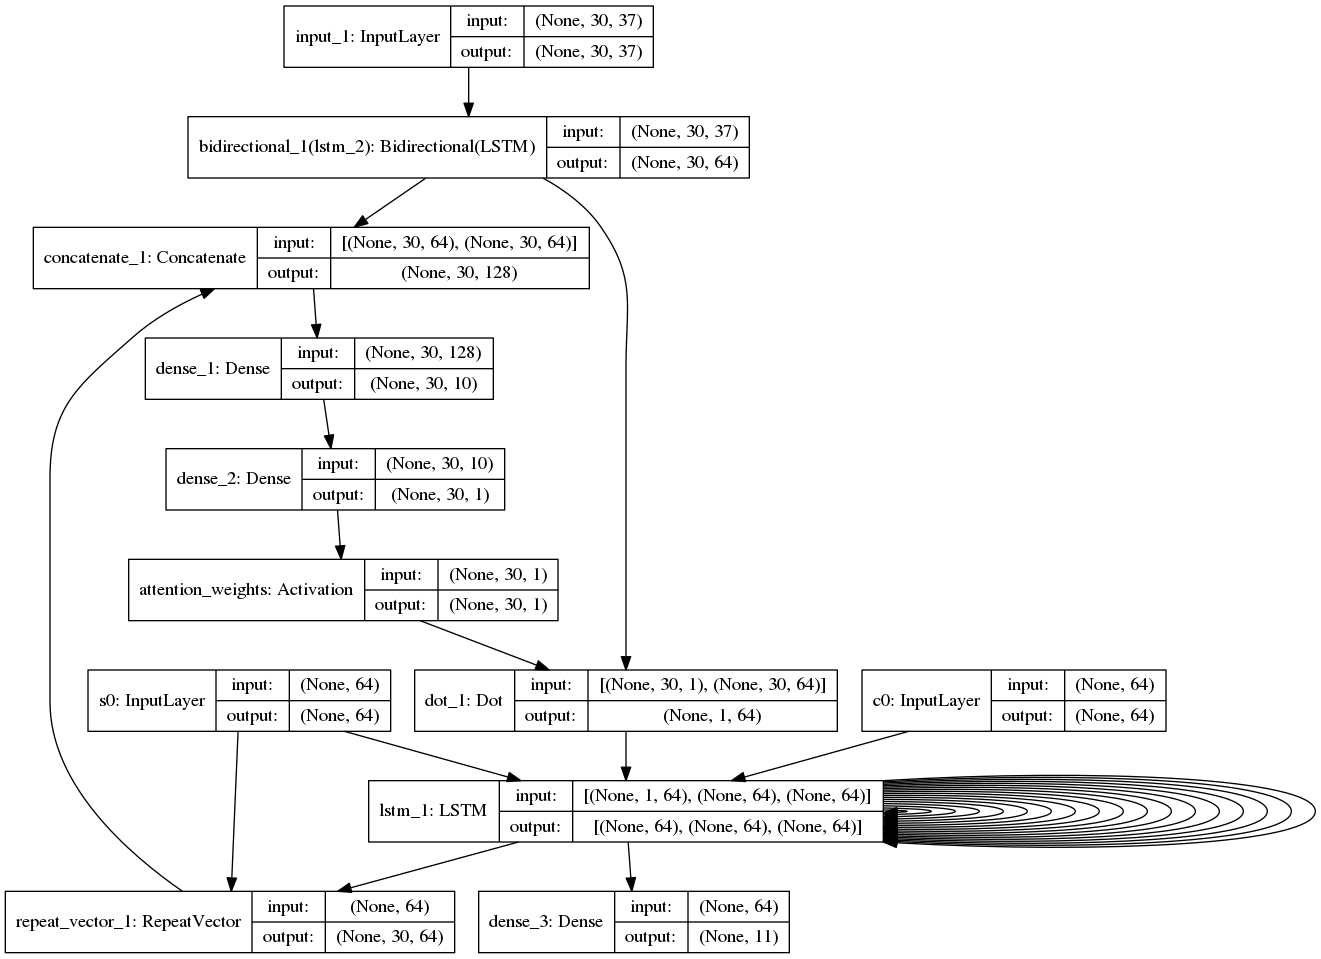

In [16]:
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# 保存到文件
plot_model(model,to_file="Attention_structure.png",show_shapes=True)
# notebook显示
SVG(model_to_dot(model).create(prog='dot',format='svg'))

from PIL import Image

# 显示本地图片
Image.open("Attention_structure.png")


In [31]:
opt=Adam(lr=0.005,beta_1=0.9,beta_2=0.999,decay=0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [32]:
s0=np.zeros((m,n_s))
c0=np.zeros((m,n_s))
outputs=list(Yoh.swapaxes(0,1))

In [33]:
model.fit([Xoh, s0, c0], outputs, epochs=50, batch_size=100)

Epoch 1/50
10000/10000 [==============================] - 13s - loss: 16.8011 - dense_6_loss_1: 1.1405 - dense_6_loss_2: 0.9764 - dense_6_loss_3: 1.7010 - dense_6_loss_4: 2.6880 - dense_6_loss_5: 0.8111 - dense_6_loss_6: 1.3757 - dense_6_loss_7: 2.7021 - dense_6_loss_8: 1.0605 - dense_6_loss_9: 1.7320 - dense_6_loss_10: 2.6139 - dense_6_acc_1: 0.5447 - dense_6_acc_2: 0.7282 - dense_6_acc_3: 0.3114 - dense_6_acc_4: 0.0740 - dense_6_acc_5: 0.9633 - dense_6_acc_6: 0.3013 - dense_6_acc_7: 0.0509 - dense_6_acc_8: 0.8825 - dense_6_acc_9: 0.2584 - dense_6_acc_10: 0.1031    
Epoch 2/50
10000/10000 [==============================] - 11s - loss: 9.0614 - dense_6_loss_1: 0.1354 - dense_6_loss_2: 0.1135 - dense_6_loss_3: 1.0192 - dense_6_loss_4: 2.1661 - dense_6_loss_5: 0.0338 - dense_6_loss_6: 0.3928 - dense_6_loss_7: 1.8798 - dense_6_loss_8: 0.0229 - dense_6_loss_9: 1.1416 - dense_6_loss_10: 2.1563 - dense_6_acc_1: 0.9702 - dense_6_acc_2: 0.9708 - dense_6_acc_3: 0.5209 - dense_6_acc_4: 0.2074 - 

10000/10000 [==============================] - 11s - loss: 0.3298 - dense_6_loss_1: 0.0161 - dense_6_loss_2: 0.0035 - dense_6_loss_3: 0.0145 - dense_6_loss_4: 0.0265 - dense_6_loss_5: 0.0010 - dense_6_loss_6: 0.0227 - dense_6_loss_7: 0.1041 - dense_6_loss_8: 0.0023 - dense_6_loss_9: 0.0966 - dense_6_loss_10: 0.0425 - dense_6_acc_1: 0.9972 - dense_6_acc_2: 0.9996 - dense_6_acc_3: 0.9996 - dense_6_acc_4: 0.9999 - dense_6_acc_5: 1.0000 - dense_6_acc_6: 0.9928 - dense_6_acc_7: 0.9696 - dense_6_acc_8: 1.0000 - dense_6_acc_9: 0.9782 - dense_6_acc_10: 0.9935    
Epoch 30/50
10000/10000 [==============================] - 12s - loss: 0.3075 - dense_6_loss_1: 0.0154 - dense_6_loss_2: 0.0032 - dense_6_loss_3: 0.0133 - dense_6_loss_4: 0.0253 - dense_6_loss_5: 9.9209e-04 - dense_6_loss_6: 0.0199 - dense_6_loss_7: 0.0986 - dense_6_loss_8: 0.0022 - dense_6_loss_9: 0.0888 - dense_6_loss_10: 0.0399 - dense_6_acc_1: 0.9972 - dense_6_acc_2: 0.9997 - dense_6_acc_3: 0.9995 - dense_6_acc_4: 0.9999 - dense_6

In [34]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-04
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


In [35]:
model.load_weights('models/model.h5')

EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 30, 64)        17920       input_2[0][0]                    
____________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_3[0][0]            

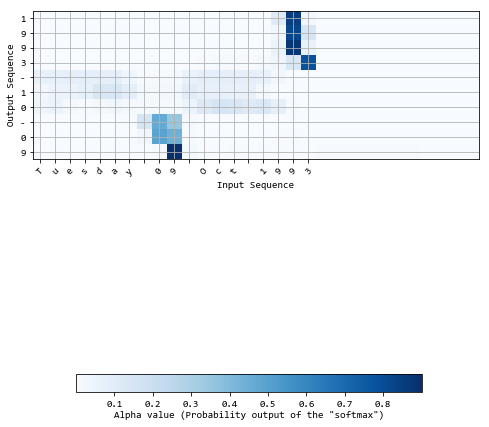

In [37]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)